In [2]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-white')

## 데이터 불러오기 

In [3]:
sound = './sound data/ESC-50-master/meta/esc50.csv'

df = pd.read_csv(sound)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
audio = []
target = []

for index, row in df.iterrows():
    audio_file = "./sound data/ESC-50-master/audio/" + row['filename']
    y, sr = librosa.load(audio_file, sr=None)
    audio.append(y)
    target.append(row['target'])

print(audio[:3])

In [5]:
print(target[:10])

[0, 14, 36, 36, 19, 19, 30, 34, 9, 30]


## 데이터 전처리

In [6]:
import numpy as np

audio_np = np.array(audio, np.float32)
target_np =np.array(target, np.float32)

print(audio_np.shape, target_np.shape)

(2000, 220500) (2000,)


In [7]:
print(type(audio_np))

<class 'numpy.ndarray'>


## 정규화

In [8]:
# normalization 2 : -1과 1 사이로 정규화
def normalize(v):
    norm = v / max(np.abs(v))
    if max(np.abs(v)) == 0:
        return v
    return norm

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 퓨리에변환(STFT)

In [49]:
audio_stft = []
for y in audio:
    S = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)
    S = np.abs(S)
    audio_stft.append(S)

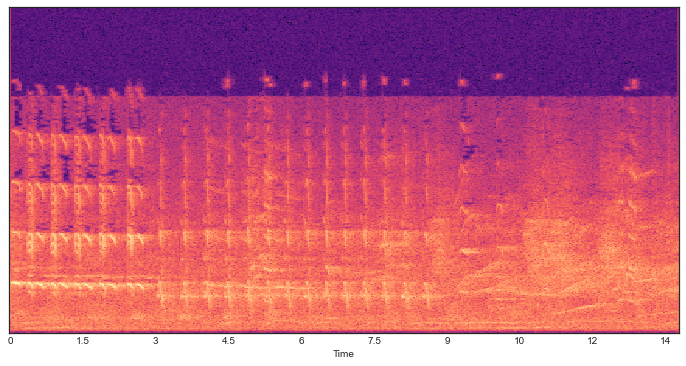

In [50]:
log_S = librosa.power_to_db(audio_stft[1], ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(log_S, sr=16000, x_axis='time');

#### 특성을 반영하여 학습 

In [51]:

stft_np = np.array(audio_stft, np.float32)
target_np = np.array(target, np.int16)

print(stft_np.shape, target_np.shape)

(2000, 513, 431) (2000,)


In [52]:
# 분류기에 사용하기 위해 3차원 벡터를 2차원 벡터로 변환 
stft_np = stft_np.reshape(2000, 513 * 431)

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(stft_np)

MinMaxScaler()

## 학습 데이터와 실험 데이터 분리

In [54]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(stft_np, target_np, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 221103)
(400, 221103)
(1600,)
(400,)


## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_X, train_y)
pred = LR.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

/Users/seyilee/mambaforge/envs/ds_study/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.235


## Support Vector Machine

In [56]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_X, train_y)
pred = SVM.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

0.225


## Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_X, train_y)
pred = DT.predict(test_X)
acc = accuracy_score(pred, test_y)
print(acc)

0.1125


## DNN 모델 구성 

In [58]:
from tensorflow.keras.utils import to_categorical

stft_np = np.array(audio_stft, np.float32)
stft_np = stft_np.reshape((2000, 513 * 431))
stft_array = np.expand_dims(stft_np, -1)
target_cat = to_categorical(target_np)

train_X, test_x, train_y, test_y = train_test_split(stft_array, target_cat, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 221103, 1)
(400, 221103)
(1600, 50)
(400, 50)


In [72]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(221103, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(218, activation='relu', name='hidden3')(output)
  output = Dense(50, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [73]:
model = model_build()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 221103)]          0         
                                                                 
 hidden1 (Dense)             (None, 512)               113205248 
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 218)               56026     
                                                                 
 output (Dense)              (None, 50)                10950     
                                                                 
Total params: 113,403,552
Trainable params: 113,403,552
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(train_X, train_y, epochs=30, validation_split=0.2)

Epoch 1/30


2022-07-07 22:57:43.653170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 49.8397 - acc: 0.0539

2022-07-07 22:57:55.080209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 13s 264ms/step - loss: 49.8397 - acc: 0.0539 - val_loss: 13.1680 - val_acc: 0.0875
Epoch 2/30
40/40 [==============================] - 10s 237ms/step - loss: 8.3980 - acc: 0.1805 - val_loss: 8.0223 - val_acc: 0.1156
Epoch 3/30
40/40 [==============================] - 10s 241ms/step - loss: 4.3758 - acc: 0.3008 - val_loss: 7.0731 - val_acc: 0.1437
Epoch 4/30
40/40 [==============================] - 9s 237ms/step - loss: 2.4807 - acc: 0.4664 - val_loss: 7.0754 - val_acc: 0.1969
Epoch 5/30
40/40 [==============================] - 10s 239ms/step - loss: 2.0016 - acc: 0.5547 - val_loss: 6.4136 - val_acc: 0.1781
Epoch 6/30
40/40 [==============================] - 10s 245ms/step - loss: 1.5130 - acc: 0.6516 - val_loss: 6.5278 - val_acc: 0.1844
Epoch 7/30
40/40 [==============================] - 10s 249ms/step - loss: 1.3733 - acc: 0.6898 - val_loss: 6.6225 - val_acc: 0.2219
Epoch 8/30
40/40 [==============================] - 10s 250ms/step - loss: 1.13

In [83]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss)+1)
  fig = plt.figure(figsize=(14, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r--', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r--', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

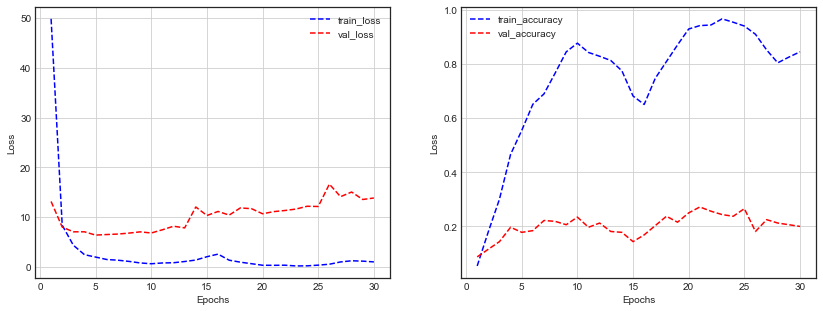

In [84]:
plot_history(history.history)

- overfitting 발생 

In [90]:
model.evaluate(test_X, test_y)

13/13 [==============================] - 2s 104ms/step - loss: 43.5977 - acc: 0.0200


[43.597713470458984, 0.019999999552965164]

## CNN 모델 

In [ ]:
stft_np = np.arrary(audio_stft, np.float32)

In [85]:
from tensorflow.keras.utils import to_categorical

stft_np = np.array(audio_stft, np.float32)
stft_array = np.expand_dims(stft_np, -1)
target_cat = to_categorical(target_np)

train_X, test_x, train_y, test_y = train_test_split(stft_array, target_cat, test_size=0.2)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1600, 513, 431, 1)
(400, 221103)
(1600, 50)
(400, 50)


In [99]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model =Sequential()

  input = Input(shape=(513, 431, 1))

  output = Conv2D(32, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(64, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(64, activation='relu')(output)
  output = Dense(32, activation='relu')(output)

  output = Dense(431, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['acc'])
  return model

In [100]:
model = model_build()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 513, 431, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 513, 431, 128)     1280      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 257, 216, 128)    0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 7105536)           0         
                                                                 
 dense_14 (Dense)            (None, 128)               909508736 
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                           

In [102]:
# history = model.fit(train_X, train_y, epochs=20, validatio
# n_split=0.2)

- CNN 모델은 로컬에서 작동하지 않음 
</br>=> 학습에 필요한 데이터로만 데이터 양을 축소해서 다시 적용해야 함
</br>=> 레이어 수를 조정(작은 것부터 점점 키워가면서 성능 확인)